# Bayesian Data Analysis of Paper on Covid-19 & Blood Type

Alfred J. Reich, Ph.D.

<i>Version 1</i>

## References

* <i><b>"Blood Type May Affect COVID-19 Risk: Study"</b></i> [WebMD](https://www.webmd.com/lung/news/20200320/blood-type-may-affect-covid19-risk-study)
* <i><b>"Relationship between the ABO Blood Group and the COVID-19 Susceptibility"</b></i> by Jiao Zhao, et al. [Abstract & link to PDF](https://www.medrxiv.org/content/10.1101/2020.03.11.20031096v1)

## Dependencies

In [1]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

# NOTE: arviz needs to be installed in the environment, but not imported directly

## Raw Data

<u><b>Excerpt from Zhao, et al:</b></u> <i>"The ABO group in 3694 normal people in Wuhan showed a distribution of 32.16%,
24.90%, 9.10% and 33.84% for A, B, AB and O, respectively, versus the distribution
of 37.75%, 26.42%, 10.03% and 25.80% for A, B, AB and O, respectively, in 1,775
COVID-19 patients from Wuhan Jinyintan Hospital. The proportion of blood group A
and O in COVID-19 patients were significantly higher and lower, respectively, than
    that in normal people (both P < 0.001)."</i>

In [2]:
# From Table 1 in the paper by Zhao, et al.

# Controls (Wuhan Area), 3694 total:
wuhan_controls = np.array([1188, 920, 336, 1250])

# Wuhan Jinyintan Hospital
# Patients, 1775 total:
wuhan_patients = np.array([670, 469, 178, 458])
# Deaths, 206 total:
wuhan_deaths = np.array([85, 50, 19, 52])

# Renmin Hospital of Wuhan University
# patients, 113 total:
renmin_patients = np.array([45, 25, 15, 28])

# Controls (Shenzhen area), 23386 total:
shenzhen_controls = np.array([6728, 5880, 1712, 9066])

# Patients from Shenzhen Third People's Hospital, 285 total:
shenzhen_patients = np.array([82, 83, 39, 81])

In [3]:
# Wuhan Controls Distribution
print(f"Wuhan Controls Total: {wuhan_controls.sum()}")

wuhan_controls_dist = wuhan_controls / wuhan_controls.sum()
print(f"Wuhan Constrols Dist:\n  [A, B, AB, O] = {wuhan_controls_dist}")

Wuhan Controls Total: 3694
Wuhan Constrols Dist:
  [A, B, AB, O] = [0.3216026  0.24905252 0.09095831 0.33838657]


In [4]:
sick_or_dead = wuhan_patients + wuhan_deaths + renmin_patients + shenzhen_patients
print(sick_or_dead)
print(f"Total = {sick_or_dead.sum()}")

[882 627 251 619]
Total = 2379


## Bayesian Data Analysis

The sick & dead results are modeled as Multinomial random variable with a Dirichlet prior, initialized using the Wuhan control data.

theta0, theta1, theta2, and theta3 coorespond to blood groups A, B, AB, and O, respectively.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 48000/48000 [00:11<00:00, 4151.83draws/s]


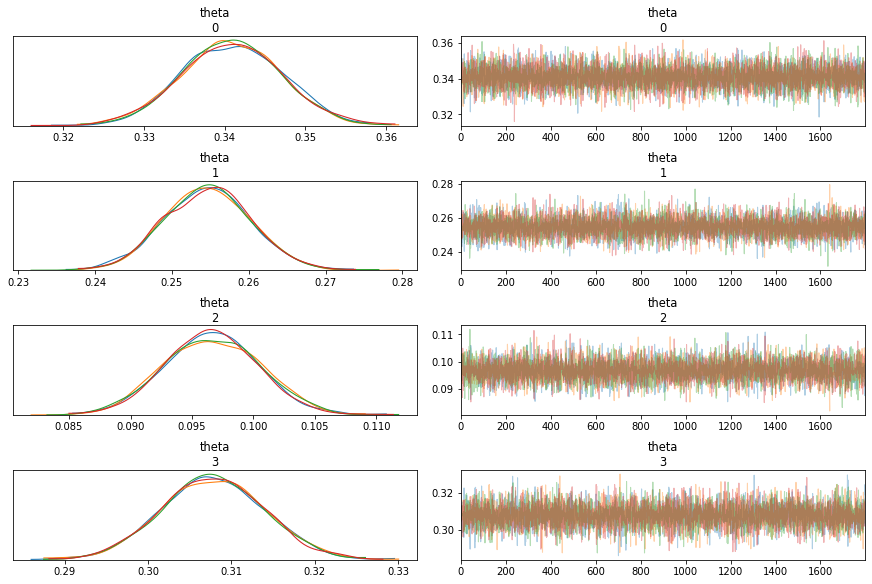

In [5]:
with pm.Model() as mod:
    theta = pm.Dirichlet('theta', a=wuhan_controls)
    post = pm.Multinomial('Posterior', n=sick_or_dead.sum(), p=theta, observed=sick_or_dead)
    trace = pm.sample(2000, tune=10000)
    pm.traceplot(trace[200:], lines={'theta':theta})

In [6]:
pm.summary(trace, alpha=0.01)

,mean,sd,mc_error,hpd_0.5,hpd_99.5,n_eff,Rhat
theta__0,0.340833,0.006068,0.000051,0.324474,0.355231,11646.067160,0.999914
theta__1,0.254699,0.005514,0.000054,0.240119,0.268281,11205.478569,0.999843
theta__2,0.096656,0.003818,0.000035,0.087008,0.106306,11233.163202,0.999756
theta__3,0.307812,0.006071,0.000057,0.292284,0.323542,11988.125913,0.999844


In [12]:
list(wuhan_controls_dist)

[0.32160259880887926,
 0.24905251759610178,
 0.09095831077422847,
 0.3383865728207905]

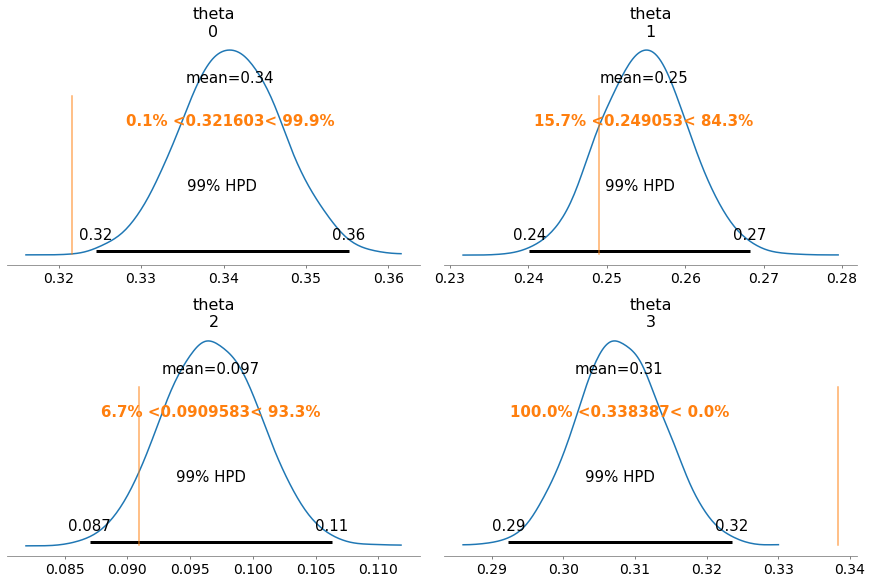

In [13]:
_, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8), constrained_layout=True)
_ = pm.plot_posterior(trace, credible_interval=0.99, ax=axes,
                      ref_val=list(wuhan_controls_dist))

In [9]:
help(pm.plot_posterior)

Help on function plot_posterior in module arviz.plots.posteriorplot:

plot_posterior(data, var_names=None, coords=None, figsize=None, textsize=None, credible_interval=0.94, multimodal=False, round_to: Union[int, NoneType] = None, point_estimate='mean', group='posterior', rope=None, ref_val=None, kind='kde', bw=4.5, bins=None, ax=None, backend=None, backend_kwargs=None, show=None, **kwargs)
    Plot Posterior densities in the style of John K. Kruschke's book.
    
    Parameters
    ----------
    data : obj
        Any object that can be converted to an az.InferenceData object
        Refer to documentation of az.convert_to_dataset for details
    var_names : list of variable names
        Variables to be plotted, two variables are required.
    coords : mapping, optional
        Coordinates of var_names to be plotted. Passed to `Dataset.sel`
    figsize : tuple
        Figure size. If None it will be defined automatically.
    textsize: float
        Text size scaling factor for label